In this notebook, I will be competing in the <a href="https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data">kaggle</a> competition, 'Sentiment Analysis on Movie Reviews'. This challenge presents us with a dataset full of movie reviews from Rotten Tomatoes. These reviews are accompanied with a five-star rating. The purpose of this challenge is to determine the five-star rating based on the text provided in the review.

This challenge is a standard sentiment analysis problem in which challenges like: sarcasm, negation and language ambiguity is presented in the dataset.

In [164]:
#Imports
import numpy as np
import pandas as pd
from tqdm import tqdm
import re

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

%matplotlib inline
import matplotlib.pyplot as plt

# First Looks at the Dataset:

In [119]:
#Read in the train data
train = pd.read_csv('./Data/train.tsv', delimiter='\t')
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [120]:
train.shape

(156060, 4)

In [121]:
train["Phrase"][0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

So our dataset contains 156060 phrases and each phrase has a 'Sentiment' class related to it. The Sentiments are described as follows:
- 0: negative
- 1: somewhat negative
- 2: neutral
- 3: somewhat positive
- 4: positive

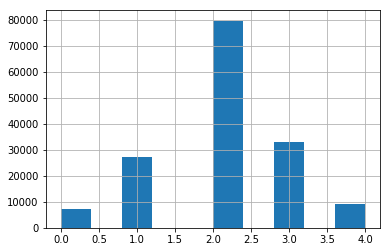

In [122]:
train['Sentiment'].hist()

So out of all our reviews, most of them ranked in the neutral category. We should keep this in mind when evaluation our model. We will be using precision and recall measurements instead of accuracy to judge the performance of our machine learning algorithm.

# Data Cleaning:

First we will clean the movie reviews. The steps we will employ to clean the text are as follows:
- Remove punctuation and numerics
- Lemmatize the words
- One hot encode the Sentiment Classes

In [123]:
clean_review = re.sub("[^a-zA-Z]" ," ",train['Phrase'][22234])
clean_review

words = word_tokenize(clean_review.lower())
words

['it', 'overstays', 'its', 'natural', 'running', 'time']

In [124]:
lemmatizer = WordNetLemmatizer()
words_lemmatized = [lemmatizer.lemmatize(i) for i in words]
words_lemmatized

['it', 'overstays', 'it', 'natural', 'running', 'time']

In [125]:
lemmatizer = WordNetLemmatizer()
def clean_reviews(df):
    reviews = []
    
    #tqdm to show progress bar
    for sentence in tqdm(df["Phrase"]):
        #Remove punctuation and numerics
        clean_review = re.sub("[^a-zA-Z]", " ", sentence)
        
        #Tokenize the sentence into a list of words
        words = word_tokenize(clean_review.lower())
        
        #Lemmatize the words
        words_lemmatized = [lemmatizer.lemmatize(word) for word in words]
        
        #Join the lemmatized words back together and append to 'reviews'
        reviews.append(' '.join(words_lemmatized))
    return reviews

In [126]:
cleaned_reviews = clean_reviews(train)

100%|██████████| 156060/156060 [00:21<00:00, 7208.97it/s]


In [127]:
len(cleaned_reviews)

156060

In [128]:
#One hot encoding the Sentiment Classes
y_train = train['Sentiment'].values
y_train = to_categorical(y_train)
y_train.shape

(156060, 5)

# Simple Model: Words to Sequence

In this model, we will simply replace the word with a numerical representation by representing each unique word by a integer.

In [147]:
#Get numer of unique words
unique_words = dict()
num_unique_words = 0
max_review_length = 0
for review in cleaned_reviews:
    words = review.split()
    i=0
    for word in words:
        i+=1
        unique_words.update({word: 1})
        num_unique_words = max(num_unique_words,len(unique_words))
        max_review_length = max(i,max_review_length)
print("Number of unique words = {}".format(num_unique_words))
print("Max Number of words in a single review = {}".format(max_review_length))

Number of unique words = 13745
Max Number of words in a single review = 48


In [151]:
#Initiate Tokenizer Object
tokenizer = Tokenizer(num_words = num_unique_words)

#Fit tokenizer on cleaned reviews
tokenizer.fit_on_texts(cleaned_reviews)

#Represent each unique word as an integer value
sequences = tokenizer.texts_to_sequences(cleaned_reviews)

#Dictionary mapping integer to its unique word
word_index = tokenizer.word_index

In [156]:
#Pad the sequences so that they are all of the same length
X_train = pad_sequences(sequences, maxlen=max_review_length)
X_train.shape

(156060, 48)

In [160]:
len(word_index)

13745

# LSTM Model

In [165]:
#Model using Keras LSTM
model=Sequential()
model.add(Embedding(input_dim=num_unique_words, output_dim=300, input_length=max_review_length, mask_zero=True))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 48, 300)           4123500   
_________________________________________________________________
lstm_10 (LSTM)               (None, 48, 128)           219648    
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_13 (Dense)             (None, 100)               6500      
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 505       
Total params: 4,399,561
Trainable params: 4,399,561
Non-trainable params: 0
_________________________________________________________________


In [166]:
model.fit(X_train,y_train,batch_size=32,epochs=5,validation_split=0.2)

/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 124848 samples, validate on 31212 samples
Epoch 1/5
124848/124848 [==============================] - 884s 7ms/step - loss: 0.9972 - acc: 0.5959 - val_loss: 1.0333 - val_acc: 0.5929
Epoch 2/5
124848/124848 [==============================] - 827s 7ms/step - loss: 0.8769 - acc: 0.6438 - val_loss: 1.0391 - val_acc: 0.5868
Epoch 3/5
124848/124848 [==============================] - 883s 7ms/step - loss: 0.8618 - acc: 0.6485 - val_loss: 1.0652 - val_acc: 0.5778
Epoch 4/5
124848/124848 [==============================] - 852s 7ms/step - loss: 0.8618 - acc: 0.6488 - val_loss: 1.0503 - val_acc: 0.5875
Epoch 5/5
124848/124848 [==============================] - 814s 7ms/step - loss: 0.8628 - acc: 0.6485 - val_loss: 1.0526 - val_acc: 0.5715


Text(0, 0.5, 'Loss')

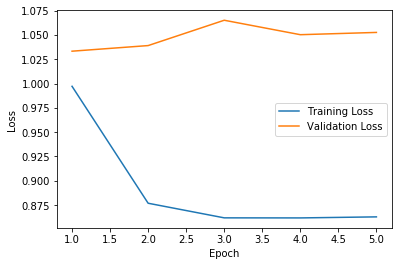

In [181]:
#Plot the losses
plt.plot(range(1,6),model.history.history['loss'])
plt.plot(range(1,6),model.history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

From the loss curve we can see that our model is overfitting, which means that our model is too complex. Let us try reducing the complexity of the model and see if that helps with overfitting.